**Libraries**

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn import tree #library for defining the algorithm
from sklearn.tree import DecisionTreeClassifier # library for creating the Decision Tree algorithm
from sklearn.decomposition import PCA #Library for PCA algorithm
from sklearn.preprocessing import LabelEncoder #library for transforming text into numeric
from sklearn.model_selection import train_test_split #library for Splitting train , test data
from sklearn.preprocessing import StandardScaler #Library for Scaling numeric features
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score  #library for testing the model quality
import matplotlib.pyplot as plt #library for visualizing graphs
from sklearn.metrics import classification_report #Library for generating reports
import joblib #Library for exporting the model

EOF


**Connecting to my drive**

In [4]:
from google.colab import drive
from google.colab import files
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data** **Loading**

In [5]:
df1=pd.read_csv("/content/drive/MyDrive/ai/FINAL/DATA/og_loan_data.csv")
df2=pd.read_csv("/content/drive/MyDrive/ai/FINAL/DATA/11.csv")

**Merging Data**

In [6]:

df2_ren = df2.rename(columns={

"Gender": "person_gender",
    "Education": "person_education",
    "ApplicantIncome": "person_income",
    "LoanAmount": "loan_amnt",
})


if "person_gender" in df2_ren.columns:
    df2_ren["person_gender"] = (
        df2_ren["person_gender"]
        .astype("string")
        .str.strip()
        .str.lower()
        .replace({"m": "male", "male": "male", "f": "female", "female": "female"})
        .astype("object")
    )


if "person_education" in df2_ren.columns:
    df2_ren["person_education"] = (
        df2_ren["person_education"]
        .astype("string")
        .str.strip()
        .str.lower()
        .replace({"graduate": "graduate", "not graduate": "not_graduate"})
        .astype("object")
    )

#Keeping missing data as it is
for col in ["person_income", "loan_amnt"]:
    if col in df2_ren.columns:
        df2_ren[col] = pd.to_numeric(df2_ren[col], errors="coerce")


#Makeing sure all df1 columns exist in df2_ren
for col in df1.columns:
    if col not in df2_ren.columns:
        df2_ren[col] = np.nan

#identifing extra columns from df2
extra_cols = [c for c in df2_ren.columns if c not in df1.columns]


#Building final column list: df1 columns + extra columns
final_cols = list(df1.columns) + extra_cols

#Merging data
df = pd.concat([df1, df2_ren], ignore_index=True, sort=False)


print("Extra columns kept from df2:", extra_cols)

Extra columns kept from df2: ['Loan_ID', 'Married', 'Dependents', 'Self_Employed', 'CoapplicantIncome', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']


**Downlowding merged data before cleaning**

In [7]:
df.to_csv("/content/drive/MyDrive/ai/dirty_data.csv", index=False)
print("The DIRTY dataset has been saved successfully")

The DIRTY dataset has been saved successfully


**Data Reading**

In [8]:
df.info()
print(df.head())
print("Numbers of columns:",df.shape[0] , ", Numbers of rows:",df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45367 entries, 0 to 45366
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45356 non-null  object 
 2   person_education                45367 non-null  object 
 3   person_income                   45367 non-null  float64
 4   person_emp_exp                  45000 non-null  float64
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45362 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  float64
 12  previous_loan_defaults_on_file  

**Data Cleaning:**

**Dropping Unwanted Columns**

In [9]:
df.drop(["loan_int_rate"], axis=1, inplace=True)
print("remaining columns:")
df.head()

remaining columns:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_percent_income,cb_person_cred_hist_length,...,previous_loan_defaults_on_file,loan_status,Loan_ID,Married,Dependents,Self_Employed,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area
0,22.0,female,Master,71948.0,0.0,RENT,35000.0,PERSONAL,0.49,3.0,...,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.0,female,High School,12282.0,0.0,OWN,1000.0,EDUCATION,0.08,2.0,...,Yes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.0,female,High School,12438.0,3.0,MORTGAGE,5500.0,MEDICAL,0.44,3.0,...,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.0,female,Bachelor,79753.0,0.0,RENT,35000.0,MEDICAL,0.44,2.0,...,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24.0,male,Master,66135.0,1.0,RENT,35000.0,MEDICAL,0.53,4.0,...,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Checking for dublicated rows**

In [10]:
print("is there any dublicated rows?",df.duplicated().any())
print("number of duplicated rows:", df.duplicated().sum())

is there any dublicated rows? False
number of duplicated rows: 0


**detacting missing values in the data**

In [11]:
print("number of missing values in the data:",df.isnull().sum().sum())
print("the percentage of the missing values in each column:\n",df.isnull().mean()) #the precentage of the missing values
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print("the columns that have missing data and how many cells missing:\n",null_columns)


number of missing values in the data: 363387
the percentage of the missing values in each column:
 person_age                        0.008090
person_gender                     0.000242
person_education                  0.000000
person_income                     0.000000
person_emp_exp                    0.008090
person_home_ownership             0.008090
loan_amnt                         0.000110
loan_intent                       0.008090
loan_percent_income               0.008090
cb_person_cred_hist_length        0.008090
credit_score                      0.008090
previous_loan_defaults_on_file    0.008090
loan_status                       0.008090
Loan_ID                           0.991910
Married                           0.991910
Dependents                        0.992131
Self_Employed                     0.992417
CoapplicantIncome                 0.991910
Loan_Amount_Term                  0.992043
Credit_History                    0.992550
Property_Area                     0.99191

**Dropping columns with full missing values (99% missing)**

In [12]:
df.drop(["Loan_ID",
    "Married",
    "Dependents",
    "Self_Employed",
    "CoapplicantIncome",
    "Loan_Amount_Term",
    "Credit_History",
    "Property_Area"
    ], axis=1, inplace=True)
print("remaining columns:")
df.head()

remaining columns:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0.0,RENT,35000.0,PERSONAL,0.49,3.0,561.0,No,1.0
1,21.0,female,High School,12282.0,0.0,OWN,1000.0,EDUCATION,0.08,2.0,504.0,Yes,0.0
2,25.0,female,High School,12438.0,3.0,MORTGAGE,5500.0,MEDICAL,0.44,3.0,635.0,No,1.0
3,23.0,female,Bachelor,79753.0,0.0,RENT,35000.0,MEDICAL,0.44,2.0,675.0,No,1.0
4,24.0,male,Master,66135.0,1.0,RENT,35000.0,MEDICAL,0.53,4.0,586.0,No,1.0


**filling missing values using mode and median**

In [13]:
print("Missing values before filling:")
print(df.isnull().sum())

# Fill categorical columns using MODE

mode_cols = ["person_gender", "person_education",
             "person_home_ownership","loan_intent",
             "previous_loan_defaults_on_file"]


for col in mode_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)


# Fill numeric columns using MEDIAN

median_cols = ["person_age", "person_income",
               "person_emp_exp","loan_amnt","loan_percent_income",
               "cb_person_cred_hist_length",
               "credit_score","loan_status"]


for col in median_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

print("Missing values after filling:")
print(df.isnull().sum())


Missing values before filling:
person_age                        367
person_gender                      11
person_education                    0
person_income                       0
person_emp_exp                    367
person_home_ownership             367
loan_amnt                           5
loan_intent                       367
loan_percent_income               367
cb_person_cred_hist_length        367
credit_score                      367
previous_loan_defaults_on_file    367
loan_status                       367
dtype: int64
Missing values after filling:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0


**Converting data from text to number**

In [14]:
le = LabelEncoder()
#Determining text columns to convert
df["person_gender"] = le.fit_transform(df["person_gender"].astype(str))
df["person_education"] = le.fit_transform(df["person_education"].astype(str))
df["person_home_ownership"] = le.fit_transform(df["person_home_ownership"].astype(str))
df["loan_intent"] = le.fit_transform(df["loan_intent"].astype(str))
df["previous_loan_defaults_on_file"] = le.fit_transform(df["previous_loan_defaults_on_file"].astype(str))
#printing columns after encoding
cols_to_show = ["person_education",
                "person_home_ownership",
                "loan_intent",
                "previous_loan_defaults_on_file"]

df[cols_to_show].head()


,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
0,4,3,4,0
1,3,2,1,1
2,3,0,3,0
3,1,3,3,0
4,4,3,3,0


**Downlowding data after cleaning file**

In [15]:
df.to_csv("/content/drive/MyDrive/ai/clean_data.csv", index=False)
print("The CLEAN dataset has been saved successfully")

The CLEAN dataset has been saved successfully


**Determining X,Y**

In [16]:
print(df.columns) #to see the whole columns and extract it
features=['person_age','person_gender' , 'person_education', 'person_income', 'person_emp_exp',
       'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file']
x=df[features] #x:all the columns exept the target
y=df['loan_status'] #y:the targeted column for prediction
print(x,y) #to make sure the whole columns are right
x.shape
y.shape

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
       'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')
       person_age  person_gender  person_education  person_income  \
0            22.0              0                 4        71948.0   
1            21.0              0                 3        12282.0   
2            25.0              0                 3        12438.0   
3            23.0              0                 1        79753.0   
4            24.0              1                 4        66135.0   
...           ...            ...               ...            ...   
45362        26.0              1                 6         4009.0   
45363        26.0              1                 5         4158.0   
45364        26.0              1                 5         3250.0   
45

(45367,)

**Splitting train , test data**

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.2, random_state=20)
print("train data",x_train) #to make sure the whole train columns are right
print("test data",x_test) #to make sure the whole test columns are right
x_train.shape
x_test.shape
y_train.shape
y_test.shape

train data        person_age  person_gender  person_education  person_income  \
35368        28.0              1                 1       151081.0   
25473        28.0              1                 3        50245.0   
883          22.0              0                 1        15248.0   
37193        34.0              1                 0       108751.0   
36158        22.0              1                 3        31546.0   
...           ...            ...               ...            ...   
31962        47.0              0                 3        78901.0   
23452        27.0              1                 3        76665.0   
23775        34.0              1                 0        79110.0   
37135        23.0              0                 3        43870.0   
27098        27.0              1                 1        30685.0   

       person_emp_exp  person_home_ownership  loan_amnt  loan_intent  \
35368             5.0                      0    20000.0            0   
25473           

(9074,)

**Scaling Features**

In [18]:
#Selecting only numerical columns
num_cols = x_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Initializing the scaler
scaler = StandardScaler()
#fitting only train data
scaler.fit(x_train[num_cols])
#copy to keep DataFrame
x_train_scaled = x_train.copy()
x_test_scaled  = x_test.copy()
#forcing numeric columns to be float
x_train_scaled.loc[:, num_cols] = x_train_scaled[num_cols].astype("float64")
x_test_scaled.loc[:,  num_cols] = x_test_scaled[num_cols].astype("float64")
# transform only the numeric columns
x_train_scaled.loc[:, num_cols] = scaler.transform(x_train[num_cols])
x_test_scaled.loc[:, num_cols]  = scaler.transform(x_test[num_cols])
print("Scaling completed successfully for numeric columns")
print("First 5 rows before scaling:")
display(x_train.head())
print("First 5 rows after scaling:")
display(x_train_scaled.head())

Scaling completed successfully for numeric columns
First 5 rows before scaling:


/tmp/ipython-input-1867099563.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.89576432  0.89576432 -1.11636507 ...  0.89576432 -1.11636507
  0.89576432]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_train_scaled.loc[:, num_cols] = scaler.transform(x_train[num_cols])
/tmp/ipython-input-1867099563.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.51256541  0.81519138 -0.51256541 ... -1.17644381  0.81519138
 -0.51256541]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_train_scaled.loc[:, num_cols] = scaler.transform(x_train[num_cols])
/tmp/ipython-input-1867099563.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.18723053  0.89724326  0.89724326 ... -1.18723053  0.8

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
35368,28.0,1,1,151081.0,5.0,0,20000.0,0,0.13,6.0,613.0,0
25473,28.0,1,3,50245.0,3.0,3,3000.0,5,0.06,6.0,581.0,1
883,22.0,0,1,15248.0,0.0,3,1000.0,5,0.07,4.0,547.0,1
37193,34.0,1,0,108751.0,11.0,0,24206.0,3,0.22,7.0,683.0,0
36158,22.0,1,3,31546.0,0.0,3,6000.0,3,0.19,3.0,533.0,1


First 5 rows after scaling:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
35368,0.048214,0.895764,-0.512565,0.851470,-0.059865,-1.187231,1.649139,-1.457331,-0.112508,0.041191,-0.391602,-1.024577
25473,0.048214,0.895764,0.815191,-0.349209,-0.395076,0.897243,-1.023142,1.442390,-0.918340,0.041191,-1.029641,0.976013
883,-0.960537,-1.116365,-0.512565,-0.765927,-0.897892,0.897243,-1.337528,1.442390,-0.803222,-0.477980,-1.707557,0.976013
37193,1.056966,0.895764,-1.176444,0.347436,0.945768,-1.187231,2.310293,0.282502,0.923561,0.300777,1.004107,-1.024577
36158,-0.960537,0.895764,0.815191,-0.571863,-0.897892,0.897243,-0.551563,0.282502,0.578205,-0.737566,-1.986699,0.976013


**PCA Algorithm**

In [19]:
# keeping 95% of the information
pca = PCA(n_components=0.95, svd_solver="full")
# fitting the pca only on the train data
pca.fit(x_train_scaled[num_cols])
# Converting digital columns into key components
train_scores = pca.transform(x_train_scaled[num_cols])
test_scores  = pca.transform(x_test_scaled[num_cols])
# Naming the components
pca_cols = [f"PCA_{i+1}" for i in range(train_scores.shape[1])]
# replacing digital columns with new components
x_train_pca = x_train_scaled.drop(columns=num_cols).copy()
x_test_pca  = x_test_scaled.drop(columns=num_cols).copy()
x_train_pca[pca_cols] = train_scores
x_test_pca[pca_cols]  = test_scores


print("PCA components:", train_scores.shape[1])


PCA components: 9


**Decision tree Algorithm**

In [20]:
# Initializing the Decision Tree Algorithm
dtree_pca = DecisionTreeClassifier(random_state=52)
# Training the model
dtree_pca.fit(x_train_pca, y_train)
# Predicting the values
y_pred_pca = dtree_pca.predict(x_test_pca)

**Testing the model with a new value**

In [21]:
#defining a new sample with encoded values
age_test = 30
income_test = 50000
education_test = 2
home_test = 1
intent_test = 3
default_test = 0
loan_amount_test = 10000
loan_percent_income_test = 0.2
cred_history_test = 5
#Making sure the input array is in the same order used during training
x_test_pca = [[
    age_test,
    income_test,
    education_test,
    home_test,
    intent_test,
    default_test,
    loan_amount_test,
    loan_percent_income_test,
    cred_history_test
]]
#predicting the new value
test_y = dtree_pca.predict(x_test_pca)
#printing the result of the prediction
print("Test Input = ", x_test_pca)
label = "approved" if test_y == 1 else "rejected" #converting Predicted Loan Status result from 0/1 to approved/rejected
print("Predicted Loan Status = ", label)

Test Input =  [[30, 50000, 2, 1, 3, 0, 10000, 0.2, 5]]
Predicted Loan Status =  approved


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


**testing the model's quality**

In [22]:
# Calculating the accuracy of the prediction in the model
print("Calculating model's quality:\n")
accuracy = accuracy_score(y_test, y_pred_pca)
print("Accuracy =", accuracy)

# Calculating the Precision of the predicted positives (approved loans) in the model
precision = precision_score(y_test, y_pred_pca, average="binary", zero_division=0)
print("Precision =", precision)

# Calculating the Recall of the predicted positives (approved loans) in the model
recall = recall_score(y_test, y_pred_pca, average="binary", zero_division=0)
print("Recall =", recall)

# Calculating F1
f1 = f1_score(y_test, y_pred_pca, average="binary", zero_division=0)
print("F1 Score =", f1)

#showing the model's quality in percent format:
print("Calculating model's quality in percentage:\n")
print("Accuracy:", accuracy * 100, "%")
print("Precision:", precision * 100, "%")
print("Recall:", recall * 100, "%")
print("F1 Score:", f1 * 100, "%")

Calculating model's quality:

Accuracy = 0.8376680625964293
Precision = 0.6175472612699952
Recall = 0.6506639427987743
F1 Score = 0.6336732156180055
Calculating model's quality in percentage:

Accuracy: 83.76680625964293 %
Precision: 61.754726126999515 %
Recall: 65.06639427987743 %
F1 Score: 63.36732156180055 %


**Plotting the model's quality**

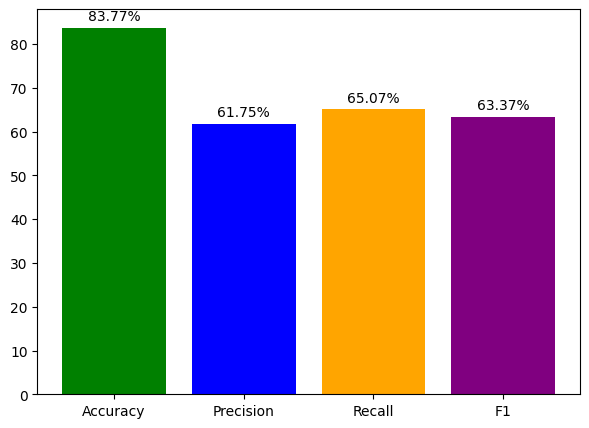

In [23]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
metrics_vals  = [accuracy, precision, recall, f1]
metrics_pct   = [v * 100 for v in metrics_vals]
plt.figure(figsize=(7, 5))
bars = plt.bar(metrics_names, metrics_pct, color=["green", "blue", "orange", "purple"])
for b, v in zip(bars, metrics_pct):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 1, f"{v:.2f}%", ha="center", va="bottom", fontsize=10)
plt.show()

**Plotting the decision tree**

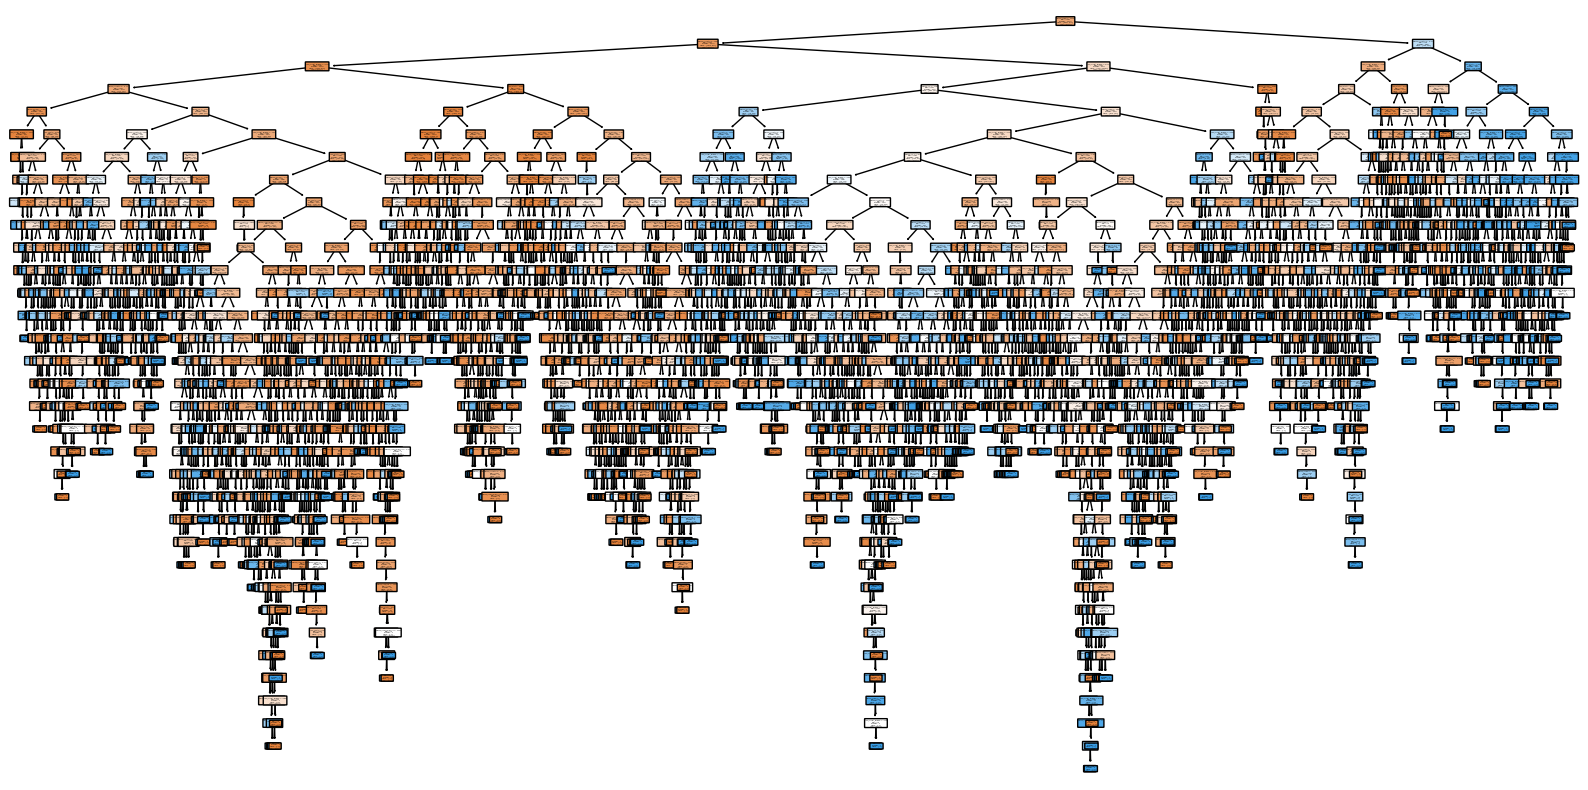

In [24]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtree_pca, filled=True, feature_names=x.columns, class_names=["rejected", "approved"], rounded=True)
plt.show()

**Classification Report**

**installing evidently library**

In [25]:
# %pip uninstall -y evidently numpy
# %pip install --no-cache-dir numpy==1.26.4 evidently==0.4.25

In [26]:
# from evidently.report import Report #Library for generating reports
# from evidently.metric_preset import DataQualityPreset #Library for generating reports
# import evidently, sys #Library for generating reports

In [27]:
# dirty = pd.read_csv("/content/drive/MyDrive/ai/dirty_data.csv")
# clean = pd.read_csv("/content/drive/MyDrive/ai/clean_data.csv")
# quality_report = Report(metrics=[DataQualityPreset()])
# quality_report.run(reference_data=dirty, current_data=clean)
# quality_report.save_html("/content/drive/MyDrive/ai/report_quality_clean.html")
# print("Data Quality Report saved successfully")

**Exporting the model as pkl**

In [40]:
joblib.dump(dtree_pca,"/content/drive/MyDrive/ai/loan_approval_v.1.pkl")
from google.colab import files
files.download("/content/drive/MyDrive/ai/loan_approval_v.1.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Loading the model**

In [38]:
model = joblib.load("/content/drive/MyDrive/ai/loan_approval_v.1.pkl")
print(model)

DecisionTreeClassifier(random_state=52)
